# Applications

In [1]:
import warnings, platform
from IPython.display import display, HTML

In [2]:
### HTML display 조정
display(HTML("<style>.container {width :98% !important;}</style>"))

### Warning 제거
warnings.filterwarnings('ignore')

## Package Load

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Business and Marketing

### (1) RFM
- Recency: 가장 최근 상품 구입일에서 오늘까지 기간
- Frequency: 상품 구매 횟수
- Monetary value: 총 구매 금액
- Customer segmentation

In [469]:
retail_df = pd.read_excel(io='./data/Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [470]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [471]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [472]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [473]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


In [474]:
# 주문 금액 컬럼 생성
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [475]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [476]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

In [477]:
### 주문번호 기준 데이터를 고객 기준 데이터로 변경
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {'InvoiceDate': 'max', 'InvoiceNo': 'count', 'sale_amount':'sum'}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)

# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'sale_amount':'Monetary'})
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


In [478]:
# Recency 계산
cust_df['Recency'] = datetime.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days + 1)
print('cust_df 로우와 컬럼 건수는 ', cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

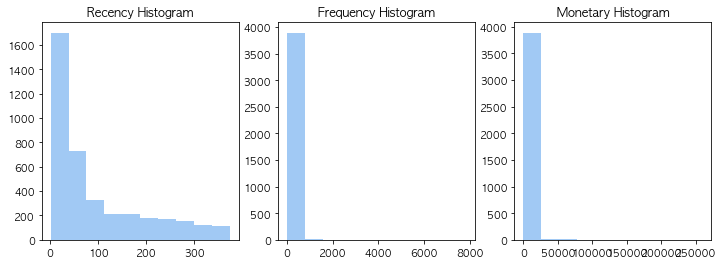

In [479]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [480]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


In [481]:
x_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
x_features_scaled = StandardScaler().fit_transform(x_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(x_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(x_features_scaled, labels)))

실루엣 스코어는 : 0.592


In [482]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

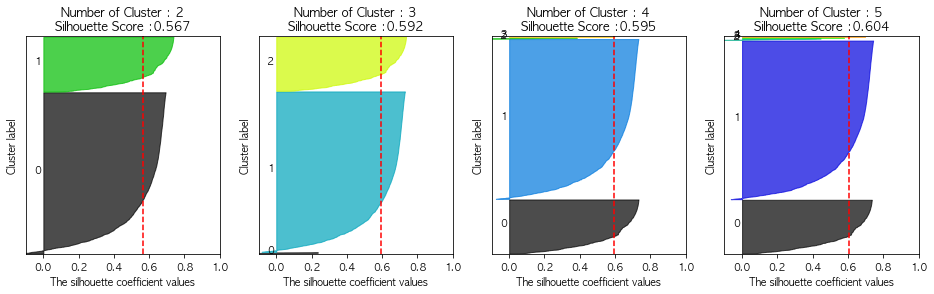

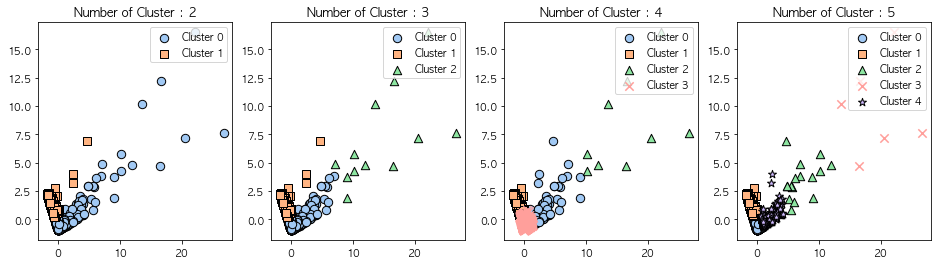

In [483]:
visualize_silhouette([2, 3, 4, 5], x_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], x_features_scaled)

In [484]:
### Log 변환을 통해 데이터 변환
# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
x_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
x_features_scaled = StandardScaler().fit_transform(x_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(x_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(x_features_scaled, labels)))

실루엣 스코어는 : 0.303


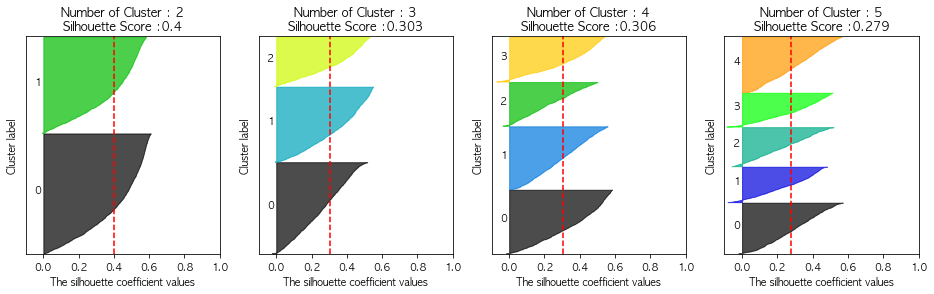

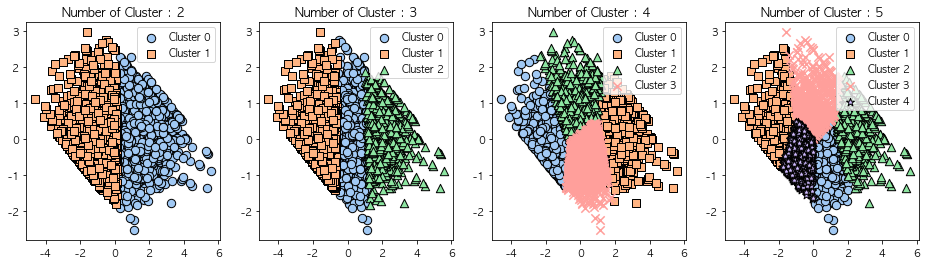

In [485]:
visualize_silhouette([2, 3, 4, 5], x_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], x_features_scaled)

### (2) Cohort Analysis
- 사용자 행동을 그룹으로 나눠 지표별로 수치화한 뒤 분석하는 기법

- 분석 주제
    - 첫 번째 구매행동 이후 몇 개월까지 구매행위가 지속되는가?
    - 구매주기는 대략적으로 얼마큼 되는가?
    - 첫 구매 날짜(브랜드 인입 시기)에 따른 최근 구매 패턴(구매, 비구매) 비교 등

- 상기 분석 목표에 따라서 변수를 설정하여야 하는데, 여기에서는 '첫구매'일로 설정함
- 구매일(OrderDate)을 YYYY-MM 형식으로 만들어줌

In [577]:
df = pd.read_excel("./data/relay-foods.xlsx", sheet_name = 'Purchase') # Purchase 
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [578]:
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02


In [579]:
# 각각 사용자의 첫 구매월을 추출하기위해 UserId를 index로 설정한 이후 groupby 함수를 사용하여 (기준 index level = 0) 'CohortGroup' 변수 추가
df = df.set_index('UserId')

# 고객 각각의 첫 구매기간 추출
df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df = df.reset_index()
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


In [580]:
# 첫구매일(년월)와 구매 날짜(년월)를 기준으로 하여 고객 수, 주문 수, 총매출 합계를 계산합니다.
# CohortGroup & OrderPeriod
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

cohorts = grouped.agg({'UserId': pd.Series.nunique, # DISTINCT COUNT 
                       'OrderId': pd.Series.nunique,
                       'TotalCharges': np.sum}) # SUM 
                       
cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01              22           30      1850.255
            2009-02               8           25      1351.065
            2009-03              10           26      1357.360
            2009-04               9           28      1604.500
            2009-05              10           26      1575.625

In [581]:
# <년월 - 년월>의 패턴을 <년월 - 소요기간(월)>로 변환하여 보기 위함
# Label the CohortPeriod for each CohortGroup
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

In [582]:
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head(20)

TotalUsers  TotalOrders  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01              22           30     1850.2550             1
            2009-02               8           25     1351.0650             2
            2009-03              10           26     1357.3600             3
            2009-04               9           28     1604.5000             4
            2009-05              10           26     1575.6250             5
            2009-06               8           26     1384.8400             6
            2009-07               8           24     1750.8400             7
            2009-08               7           21     1426.5714             8
            2009-09               7           24     1964.2755             9
            2009-10               7           13      860.3292            10
            2009-11               7           21     1821.8153            11
            2009-12               8           22     2152.1165            12
            2010-01              11           25     2084.2236            13
            2010-02               7           19     2068.7771            14
            2010-03               6           12     1504.3325            15
2009-02     2009-02              15           15      666.3100             1
            2009-03               3            8      501.6100             2
            2009-04               5           10      968.7800             3
            2009-05               1            2       53.3600             4
            2009-06               4            9      758.5200             5

In [583]:
cohorts.reset_index(inplace=True)

In [584]:
# Retention 결과를 (%) 비율로 나타내기 위해 각각 첫 구매일(년월)에 따른 회원수를 구합니다.
# 2009-01 에 첫 구매한 회원수 22명 , 2월에 첫 구매한 회원수 15명
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

In [585]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,32.0,50.0,31.0,37.0,54.0,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,15.0,23.0,11.0,15.0,17.0,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,9.0,13.0,9.0,14.0,12.0,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,6.0,10.0,7.0,8.0,13.0,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,7.0,11.0,6.0,13.0,13.0,13.0,NaN,NaN,NaN,NaN


In [586]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.00000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,0.46875,0.46,0.354839,0.405405,0.314815,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,0.28125,0.26,0.290323,0.378378,0.222222,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,0.18750,0.20,0.225806,0.216216,0.240741,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,0.21875,0.22,0.193548,0.351351,0.240741,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,0.15625,0.20,0.258065,0.243243,0.129630,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,0.09375,0.22,0.129032,0.216216,NaN,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,0.09375,0.14,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,0.31250,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


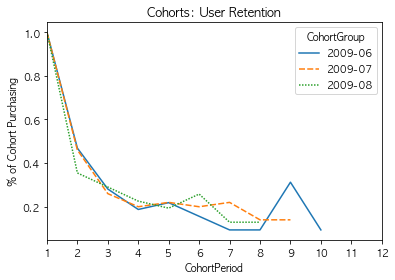

In [587]:
sns.lineplot(data=user_retention[['2009-06', '2009-07', '2009-08']])
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

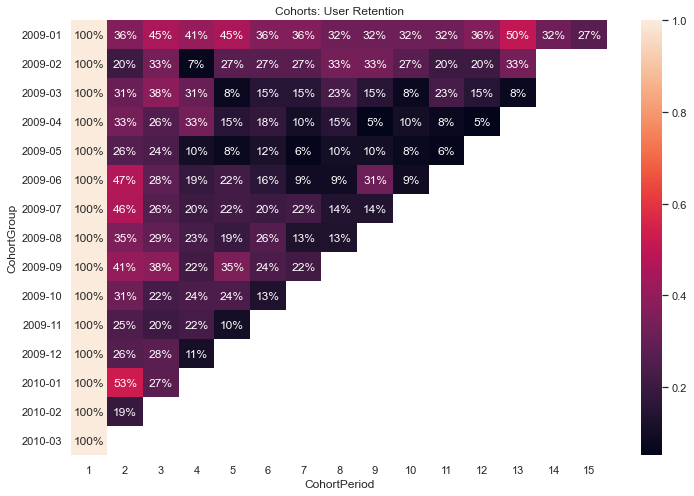

In [588]:
# 그래프는 각각 브랜드에 유입된 시기를 비교하여 첫구매 이후 고객들의 구매패턴을 나타낸 것입니다.
# 2009년 07월에 유입된 고객들의 패턴을 기준으로 살펴보면 첫 구매 이후 한 달 뒤 46%가 구매행동을 보였고 8개월이 지난 후에는 14%만이 구매행동을 보였습니다.
# 여기서 자세히 살펴보면 최근 기준으로 구매행동을 보인 고객들의 유입 날짜(년월)를 확인할 수 있습니다.
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

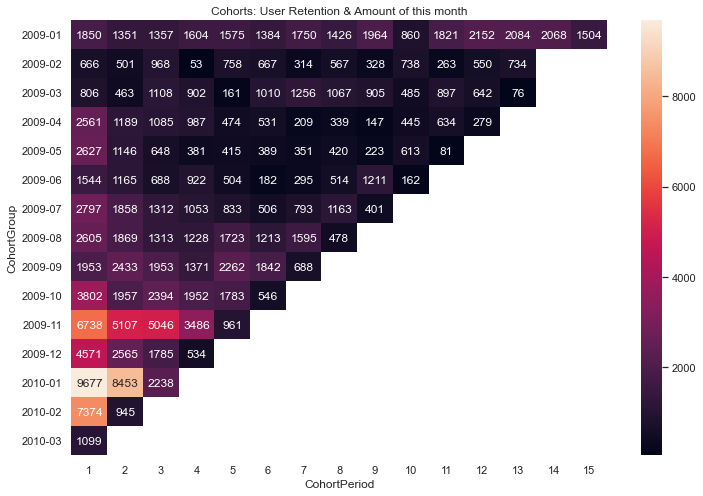

In [589]:
# 최근 발생한 매출의 회원들의 첫 구매일 분포
plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention & Amount of this month')
sns.heatmap(cohorts['TotalCharges'].unstack(0).T.fillna(0).astype('int'), 
            mask=user_retention.T.isnull(), annot=True, fmt= '0');

### (3) Positioning Analysis

### (4) Conjoint Analysis

### (5) A/B Test
- 두 그룹 비교
- 실험군과 대조군, 임의화 (처리 적용 대상 임의로 결정)
- Multi-armed bandit
    - 전통적인 A/B test가 어려운 경우
        - 표본의 크기가 충분하지 않은 경우
        - 실험이 끝나기 전에, 이미 얻은 결과들을 이용하는 경우
        - 추가적으로 들어오는 데이터를 바탕으로 다른 것 시도
    - Epsilon-greedy algorithm
        - 0~1 사이의 난수 생성
        - 난수가 0과 Epsilon 사이이면, 동전 뒤집기 (50/50) 시행
        - 앞면이면 제안 A, 뒷면이면 제안 B
        - 난수가 Epsilon보다 크면, 지금까지 가장 좋은 결과를 보인 제안 표시
    - Thompson's sampling
        - 표본을 추출하여, 최고의 손잡이를 선택할 확률 최대화
        - Beta distribution (Bayes 사전 분포) 사용

## Recommendations
- Content based filtering: 사용자가 특정한 아이템을 선호하는 경우, 비슷한 콘텐츠의 다른 아이템을 추천하는 것
- Collaborative filtering: 평점 정보나, 상품 구매 이력과 같은 사용자 행동(User Behavior) 기반 추천
    - NN filtering: 사용자 기반과 아이템 기반으로 구분
        - 사용자 기반: 특정 사용자와 유사한 다른 사용자를 Top-N으로 선정, Top-N이 좋아하는 아이템 추천
        - 아이템 기반: 사용자들의 아이템 선호 평가 척도가 유사한 아이템 추천 (사용자 기반보다 성능 좋음)
    - Latent Factor filtering: 행렬 분해를 이용한 방법. 사용자-아이템 행렬의 잠재 요인 추출 

### (1) Content based filtering

In [6]:
movies =pd.read_csv('./data/tmdb-5000-movie-dataset/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [7]:
movies_df = movies[['id','title', 'genres', 'vote_average', 'vote_count','popularity', 'keywords', 'overview']]

pd.set_option('max_colwidth', 100)
movies_df[['genres','keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


In [8]:
from ast import literal_eval

In [9]:
movies_df['genres'] = movies_df['genres'].apply(literal_eval) # 문자열을 해석해서 객체로 반환
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

movies_df['genres'] = movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환. 
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=0.0, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

# 장르 유사도 계산 -> 장르 기반 콘텐츠 필터링
genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

(4803, 276)
(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]
[[   0 3494  813 ... 3038 3037 2401]]


In [14]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


In [15]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:',round(C, 3), 'm:',round(m, 3))

C: 6.092 m: 370.2


In [18]:
# 가중 평점 계산
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    
    return ((v/(v+m)) * R) + ((m/(m+v)) * C) 

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1) 
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [20]:
top_n = 10
title_movie = movies_df[movies_df['title']=='The Godfather']
title_index = title_movie.index.values
    
# top_n의 2배에 해당하는 쟝르 유사성이 높은 index 추출 
similar_indexes = genre_sim_sorted_ind[title_index, :(top_n*2)]
similar_indexes = similar_indexes.reshape(-1)
# 기준 영화 index는 제외
similar_indexes = similar_indexes[similar_indexes != title_index]
    
# top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n 만큼 추출 
similar_movies = movies_df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


### (2) NN-Collaborative filtering

In [21]:
### Movie rating data
movies = pd.read_csv('./data/ml-latest-small/movies.csv')
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


In [22]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [23]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [24]:
# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행. 
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0 으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
### 영화의 유사도 산출
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T) # 코사인 유사도 계산 시, 행 기준으로 유사도가 계산되므로 Transpose

# cosine_similarity() 로 반환된 넘파이 행렬을 영화명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                          columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [28]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

In [29]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

In [30]:
ratings_pred = ratings_matrix.values.dot(item_sim_df.values) / np.array([np.abs(item_sim_df.values).sum(axis=1)])
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


In [31]:
# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 를 구함. 
pred = ratings_pred[ratings_matrix.values.nonzero()].flatten()
actual = ratings_matrix.values[ratings_matrix.values.nonzero()].flatten()

print('아이템 기반 모든 인접 이웃 MSE: ', mean_squared_error(pred, actual))

아이템 기반 모든 인접 이웃 MSE:  9.895354759094706


In [33]:
# 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
ratings_pred = np.zeros(ratings_matrix.shape)
n = 20

# 사용자-아이템 평점 행렬의 열 크기만큼 Loop 수행. 
for col in range(ratings_matrix.values.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 index 반환
    top_n_items = [np.argsort(item_sim_df.values[:, col])[:-n-1:-1]]
    
    # 개인화된 예측 평점을 계산
    for row in range(ratings_matrix.values.shape[0]):
        ratings_pred[row, col] = item_sim_df.values[col, :][top_n_items].dot(ratings_matrix.values[row, :][top_n_items].T) 
        ratings_pred[row, col] /= np.sum(np.abs(item_sim_df.values[col, :][top_n_items]))

pred = ratings_pred[ratings_matrix.values.nonzero()].flatten()
actual = ratings_matrix.values[ratings_matrix.values.nonzero()].flatten()

pred = ratings_pred[ratings_matrix.values.nonzero()].flatten()
actual = ratings_matrix.values[ratings_matrix.values.nonzero()].flatten()
print('아이템 기반 인접 TOP-20 이웃 MSE: ', mean_squared_error(pred, actual))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)

아이템 기반 인접 TOP-20 이웃 MSE:  3.6949999176225483


In [34]:
# 9번 user 아이템 추천
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[ user_rating_id > 0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

In [35]:
user_id = 9
top_n = 10
# userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함. 
# 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임. 
user_rating = ratings_matrix.loc[user_id,:]
    
# user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
already_seen = user_rating[ user_rating > 0].index.tolist()
    
# 모든 영화명을 list 객체로 만듬. 
movies_list = ratings_matrix.columns.tolist()
    
 # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함. 
unseen_list = [movie for movie in movies_list if movie not in already_seen]

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
recomm_movies = ratings_pred_matrix.loc[user_id, unseen_list].sort_values(ascending=False)[:top_n]

# 평점 데이타를 DataFrame으로 생성. 
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


### (3) Latent Fatcor Collaborative filtering

In [36]:
# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재요인 차원 K는 3 설정. 
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN],
              [np.NaN, 5, np.NaN, 3, 1],
              [np.NaN, np.NaN, 3, 4, 4],
              [5, 2, 1, 2, np.NaN ]])
num_users, num_items = R.shape
K = 3

# P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 random한 값으로 입력합니다. 
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))

In [37]:
# R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트에 저장. 
non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

steps=1000
learning_rate=0.01
r_lambda=0.01

# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트. 
for step in range(steps):
    for i, j, r in non_zeros:
        # 실제 값과 예측 값의 차이인 오류 값 구함
        eij = r - np.dot(P[i, :], Q[j, :].T)
        # Regularization을 반영한 SGD 업데이트 공식 적용
        P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
        Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    rmse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros, squared=True)

    if (step % 50) == 0 :
        print("### iteration step : ", step," rmse : ", rmse)

### iteration step :  0  rmse :  10.489858008094606
### iteration step :  50  rmse :  0.2378242820743239
### iteration step :  100  rmse :  0.024471608395764264
### iteration step :  150  rmse :  0.0055579131981562
### iteration step :  200  rmse :  0.001870758685914867
### iteration step :  250  rmse :  0.000855464736474408
### iteration step :  300  rmse :  0.000511714895592624
### iteration step :  350  rmse :  0.0003800018521624787
### iteration step :  400  rmse :  0.0003248184034739271
### iteration step :  450  rmse :  0.0002999715215258849
### iteration step :  500  rmse :  0.0002881050620843007
### iteration step :  550  rmse :  0.0002821326446326989
### iteration step :  600  rmse :  0.0002789341866730162
### iteration step :  650  rmse :  0.00027704726688556014
### iteration step :  700  rmse :  0.0002757562491934786
### iteration step :  750  rmse :  0.0002747041214088558
### iteration step :  800  rmse :  0.0002737143862568511
### iteration step :  850  rmse :  0.000272703

In [38]:
pred_matrix = np.dot(P, Q.T)
print('예측 행렬:\n', np.round(pred_matrix, 3))

예측 행렬:
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]


In [42]:
### 평점 data
movies = pd.read_csv('./data/ml-latest-small/movies.csv')
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행. 
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [44]:
learning_rate = 0.01
r_lambda = 0.01

num_users, num_items = ratings_matrix.values.shape
# P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다. 
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users, 50))
Q = np.random.normal(scale=1./K, size=(num_items, 50))
       
# R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장. 
non_zeros = [(i, j, ratings_matrix.values[i, j]) for i in range(num_users) for j in range(num_items) if ratings_matrix.values[i, j] > 0]
   
# SGD기법으로 P와 Q 매트릭스를 계속 업데이트. 
for step in range(50):
    for i, j, r in non_zeros:
        # 실제 값과 예측 값의 차이인 오류 값 구함
        eij = r - np.dot(P[i, :], Q[j, :].T)
        # Regularization을 반영한 SGD 업데이트 공식 적용
        P[i,:] = P[i,:] + learning_rate * (eij * Q[j, :] - r_lambda * P[i,:])
        Q[j,:] = Q[j,:] + learning_rate * (eij * P[i, :] - r_lambda * Q[j,:])

    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = ratings_matrix.values[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    rmse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros, squared=False)
        
    if (step % 10)==0:
        print("### iteration step : ", step," rmse : ", rmse)

pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.0717791959148006
### iteration step :  10  rmse :  0.5952870975148773
### iteration step :  20  rmse :  0.4524896385109734
### iteration step :  30  rmse :  0.37555819321238143
### iteration step :  40  rmse :  0.3257058371350899


In [45]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.024936,3.231657,2.829900,1.571918,2.976605,0.471146,3.117651,2.890183,3.658056,3.385123,...,1.207380,4.487529,4.075184,1.237870,2.703429,3.311083,3.356250,0.764282,3.767842,-0.558328
2,3.839375,1.301829,1.355599,0.408130,2.572278,0.836684,2.556986,1.834892,2.947071,1.668475,...,-0.014990,3.133485,2.306486,2.189401,2.292841,4.240153,2.989056,0.177497,3.171962,-0.056720
3,0.458599,-1.603826,-2.293100,-0.605816,-0.964758,2.986235,3.405222,0.794336,3.499173,1.289469,...,-1.608229,0.344913,0.624315,-0.248631,1.730700,1.245388,2.597360,0.568558,0.163399,0.187138


In [46]:
# 사용자가 관람하지 않는 영화명 추출   
# userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함. 
# 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임. 
user_id = 9
top_n = 10
user_rating = ratings_matrix.loc[user_id, :]
    
# user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
already_seen = user_rating[ user_rating > 0].index.tolist()
    
# 모든 영화명을 list 객체로 만듬. 
movies_list = ratings_matrix.columns.tolist()
    
# list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함. 
unseen_list = [ movie for movie in movies_list if movie not in already_seen]

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
recomm_movies = ratings_pred_matrix.loc[user_id, unseen_list].sort_values(ascending=False)[:top_n]

# 평점 데이타를 DataFrame으로 생성. 
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Identity (2003),6.678386
"Grifters, The (1990)",6.328209
Hoop Dreams (1994),6.305994
Rear Window (1954),6.000280
Gonzo: The Life and Work of Dr. Hunter S. Thompson (2008),5.924929
Death and the Maiden (1994),5.923479
Machete (2010),5.834834
Glory (1989),5.760827
Inside Man (2006),5.700593


### (4) Surprise package

In [49]:
# !pip install surprise
from surprise import SVD
from surprise import Dataset 
from surprise import accuracy 
from surprise.model_selection import train_test_split

In [50]:
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0) 

Dataset ml-100k could not be found. Do you want to download it? [Y/n] 

 y


Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /Users/hyunjoong/.surprise_data/ml-100k


In [51]:
algo = SVD(random_state=0)
algo.fit(trainset) 

In [52]:
predictions = algo.test(testset) # 전체 추천 예측
print('prediction type :',type(predictions), ' size:',len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type : <class 'list'>  size: 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.5738724195814906, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472446, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.846363949593691, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

In [53]:
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.5738724195814906),
 ('535', '507', 4.033583485472446)]

In [54]:
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함. 
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid) # 개별 사용자와 아이템에 대한 추천 예측
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


In [55]:
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948

In [56]:
### Reader & Dataset
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
# ratings_noh.csv 파일로 unload 시 index 와 header를 모두 제거한 새로운 파일 생성.  
ratings.to_csv('./data/ml-latest-small/ratings_noh.csv', index=False, header=False)

In [57]:
from surprise import Reader, Dataset

In [58]:
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5)) # 실제 로드는 앞 3개 컬럼만 됨 (유저 아이템 평점)
data = Dataset.load_from_file('./data/ml-latest-small/ratings_noh.csv', reader=reader)

In [59]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

In [60]:
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv') 
reader = Reader(rating_scale=(0.5, 5.0)) 

# ratings DataFrame 에서 컬럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다. 
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

In [61]:
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [62]:
### Cross validataion
algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8688  0.8809  0.8679  0.8758  0.8726  0.8732  0.0048  
MAE (testset)     0.6697  0.6765  0.6686  0.6715  0.6695  0.6712  0.0028  
Fit time          0.37    0.36    0.37    0.36    0.45    0.38    0.03    
Test time         0.04    0.05    0.05    0.12    0.05    0.06    0.03    


{'test_rmse': array([0.86875695, 0.88092589, 0.86790862, 0.87578182, 0.87258328]),
 'test_mae': array([0.66974362, 0.67645239, 0.66859186, 0.67147973, 0.6695167 ]),
 'fit_time': (0.37077999114990234,
  0.3631479740142822,
  0.37027406692504883,
  0.3610649108886719,
  0.4453718662261963),
 'test_time': (0.044571876525878906,
  0.04541015625,
  0.04537796974182129,
  0.11718511581420898,
  0.04627513885498047)}

In [63]:
# 최적화할 파라미터를 딕셔너리 형태로 지정
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8776388808022743
{'n_epochs': 20, 'n_factors': 50}


In [64]:
from surprise.dataset import DatasetAutoFolds

In [65]:
### 영화 추천 시스템 구축
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성. 
data_folds = DatasetAutoFolds(ratings_file='./data/ml-latest-small/ratings_noh.csv', reader=reader)

#전체 데이터를 학습데이터로 생성함
trainset = data_folds.build_full_trainset()

In [66]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [67]:
# 영화에 대한 상세 속성 정보 DataFrame로딩
movies = pd.read_csv('./data/ml-latest-small/movies.csv')

# user_id=9 의 movieId 데이터 추출하여 movieId=42 데이터가 있는지 확인. 
movieIds = ratings[ratings['userId']==9]['movieId']
if movieIds[movieIds==42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [68]:
uid = str(9)
iid = str(42)
pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [69]:
# 사용자가 평점을 매긴 모든 영화를 리스트로 생성
user_id = 9
seen_movies = ratings[ratings['userId']==user_id]['movieId'].tolist()
    
# 모든 영화들의 movieId를 리스트로 생성. 
total_movies = movies['movieId'].tolist()
    
# 모든 영화들의 movieId중 이미 평점을 매긴 영화의 movieId를 제외하여 리스트로 생성
unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
print('평점 매긴 영화수:',len(seen_movies), '추천대상 영화수:',len(unseen_movies), '전체 영화수:',len(total_movies))   

평점 매긴 영화수: 46 추천대상 영화수: 9696 전체 영화수: 9742


In [70]:
user_id = 9
top_n=10

# 사용자가 평점을 매긴 모든 영화를 리스트로 생성
seen_movies = ratings[ratings['userId']==user_id]['movieId'].tolist()
    
# 모든 영화들의 movieId를 리스트로 생성. 
total_movies = movies['movieId'].tolist()
    
# 모든 영화들의 movieId중 이미 평점을 매긴 영화의 movieId를 제외하여 리스트로 생성
unseen_movies = [movie for movie in total_movies if movie not in seen_movies]
print('평점 매긴 영화수:',len(seen_movies), '추천대상 영화수:',len(unseen_movies), '전체 영화수:',len(total_movies))

# 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
predictions = [algo.predict(str(user_id), str(movie_id)) for movie_id in unseen_movies]
    
# predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
# [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]
# 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
# sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
def sortkey_est(pred):
    return pred.est
    
# sortkey_est() 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출
predictions.sort(key=sortkey_est, reverse=True)
top_predictions= predictions[:top_n]
    
# top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
top_movie_ids = [int(pred.iid) for pred in top_predictions]
top_movie_rating = [pred.est for pred in top_predictions]
top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
top_movie_preds = [(id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]
print('##### Top-10 추천 영화 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])

평점 매긴 영화수: 46 추천대상 영화수: 9696 전체 영화수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122758
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122658
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957


## Optimization

### (1) Linear Programming